# SNU-NVIDIA MONAI Bootcamp (optional) Zeroshot image classification

## OpenAI CLIP

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.

<img src="https://miro.medium.com/v2/resize:fit:3662/1*tg7akErlMSyCLQxrMtQIYw.png" width=800>

- Official OpenAI CLIP [github](https://github.com/openai/CLIP)
- community OpenCLIP [openclip_torch](https://github.com/mlfoundations/open_clip)

#  Pubmed-CLIP
 
 - paper :  Sedigheh Eslami, Gerard de Melo, and Christoph Meinel, oes CLIP Benefit Visual Question Answering in the Medical Domain as Much as it Does in the General Domain?

 - Abstract : 
Contrastive Language--Image Pre-training (CLIP) has shown remarkable success in learning with cross-modal supervision from extensive amounts of image--text pairs collected online. Thus far, the effectiveness of CLIP has been investigated primarily in general-domain multimodal problems. This work evaluates the effectiveness of CLIP for the task of Medical Visual Question Answering (MedVQA). To this end, we present PubMedCLIP, a fine-tuned version of CLIP for the medical domain based on PubMed articles. Our experiments are conducted on two MedVQA benchmark datasets and investigate two MedVQA methods, MEVF (Mixture of Enhanced Visual Features) and QCR (Question answering via Conditional Reasoning). For each of these, we assess the merits of visual representation learning using PubMedCLIP, the original CLIP, and state-of-the-art MAML (Model-Agnostic Meta-Learning) networks pre-trained only on visual data. We open source the code for our MedVQA pipeline and pre-training PubMedCLIP. CLIP and PubMedCLIP achieve improvements in comparison to MAML's visual encoder. PubMedCLIP achieves the best results with gains in the overall accuracy of up to 3%. Individual examples illustrate the strengths of PubMedCLIP in comparison to the previously widely used MAML networks. Visual representation learning with language supervision in PubMedCLIP leads to noticeable improvements for MedVQA. Our experiments reveal distributional differences in the two MedVQA benchmark datasets that have not been imparted in previous work and cause different back-end visual encoders in PubMedCLIP to exhibit different behavior on these datasets. Moreover, we witness fundamental performance differences of VQA in general versus medical domains.
 
  - URLs
    -  [arxiv](https://arxiv.org/abs/2112.13906)   
    -  [github](https://github.com/sarahESL/PubMedCLIP)   
    -  [huggingface](https://huggingface.co/flaviagiammarino/pubmed-clip-vit-base-patch32)
)

In [25]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel


In [26]:

model = CLIPModel.from_pretrained("flaviagiammarino/pubmed-clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("flaviagiammarino/pubmed-clip-vit-base-patch32")


In [27]:

url = "https://huggingface.co/flaviagiammarino/pubmed-clip-vit-base-patch32/resolve/main/scripts/input.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
text = ["Chest X-Ray", "Brain MRI", "Abdominal CT Scan", "pathology", "CCTV" , "ultrasound" ]

In [28]:
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
probs = model(**inputs).logits_per_image.softmax(dim=1).squeeze()

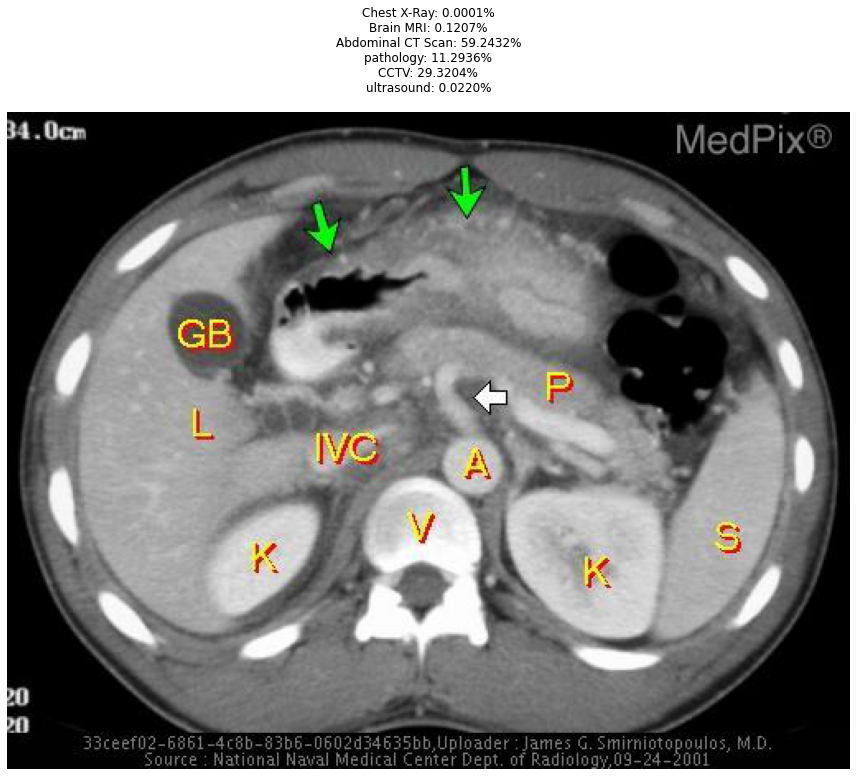

In [29]:
plt.subplots(figsize=(12,12))
plt.imshow(image)
plt.title("".join([x[0] + ": " + x[1] + "\n" for x in zip(text, [format(prob, ".4%") for prob in probs])]))
plt.axis("off")
plt.tight_layout()
plt.show()

## Pathology Examples

[LINK](https://www.mybiosource.com/polyclonal-human-mouse-rat-antibody/erk1-2/9600613#QLAPP_MBS9600613_IHC)

<img src="https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IHC5.jpg" width=400>
<img src="https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IHC9.jpg" width=400>
<img src="https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IHC4.jpg" width=400>
<img src="https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IHC.jpg" width=400>
<img src="https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IF7.jpg" width=400>

In [34]:
url = "https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IHC5.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = ["Chest X-Ray", "Brain MRI", "Abdominal CT Scan", "pathology", "CCTV" , "ultrasound" ]

In [35]:
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
probs = model(**inputs).logits_per_image.softmax(dim=1).squeeze()

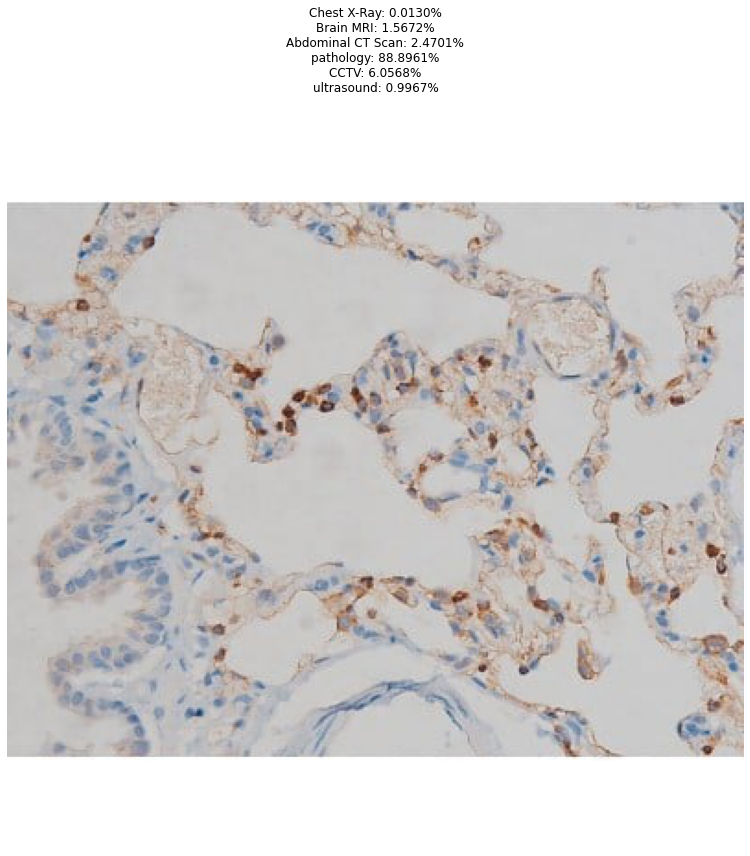

In [36]:
plt.subplots(figsize=(12,12))
plt.imshow(image)
plt.title("".join([x[0] + ": " + x[1] + "\n" for x in zip(text, [format(prob, ".4%") for prob in probs])]))
plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
url = "https://cdn.mybiosource.com/tds/protocol_images/7000000-9999999/MBS9600613_IF7.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = ["Chest X-Ray", "Brain MRI", "Abdominal CT Scan", "pathology", "CCTV" , "ultrasound" , "fluorescence"]

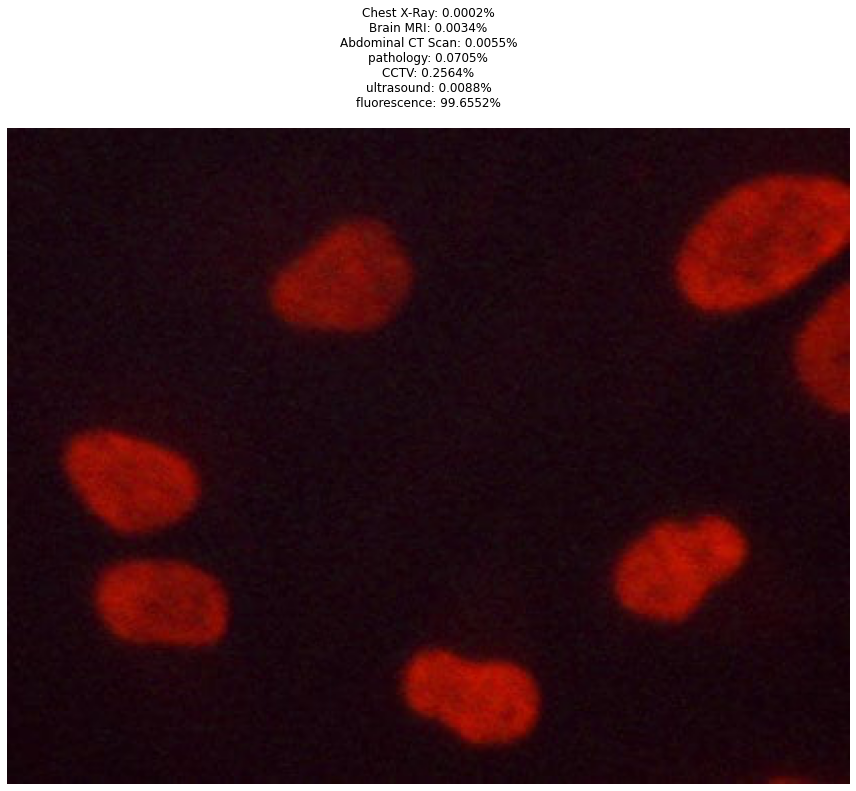

In [38]:
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
probs = model(**inputs).logits_per_image.softmax(dim=1).squeeze()
plt.subplots(figsize=(12,12))
plt.imshow(image)
plt.title("".join([x[0] + ": " + x[1] + "\n" for x in zip(text, [format(prob, ".4%") for prob in probs])]))
plt.axis("off")
plt.tight_layout()
plt.show()

# BioMedCLIP


- paper : Sheng Zhang, Yanbo Xu, Naoto Usuyama, Jaspreet Bagga, Robert Tinn, Sam Preston, Rajesh Rao, Mu Wei, Naveen Valluri, Cliff Wong, Matthew P. Lungren, Tristan Naumann, Hoifung Poon, "Large-Scale Domain-Specific Pretraining for Biomedical Vision-Language Processing"
- Abstract :
Contrastive pretraining on parallel image-text data has attained great success in vision-language processing (VLP), as exemplified by CLIP and related methods. However, prior explorations tend to focus on general domains in the web. Biomedical images and text are rather different, but publicly available datasets are small and skew toward chest X-ray, thus severely limiting progress. In this paper, we conducted by far the largest study on biomedical VLP, using 15 million figure-caption pairs extracted from biomedical research articles in PubMed Central. Our dataset (PMC-15M) is two orders of magnitude larger than existing biomedical image-text datasets such as MIMIC-CXR, and spans a diverse range of biomedical images. The standard CLIP method is suboptimal for the biomedical domain. We propose BiomedCLIP with domain-specific adaptations tailored to biomedical VLP. We conducted extensive experiments and ablation studies on standard biomedical imaging tasks from retrieval to classification to visual question-answering (VQA). BiomedCLIP established new state of the art in a wide range of standard datasets, substantially outperformed prior VLP approaches. Surprisingly, BiomedCLIP even outperformed radiology-specific state-of-the-art models such as BioViL on radiology-specific tasks such as RSNA pneumonia detection, thus highlighting the utility in large-scale pretraining across all biomedical image types. We will release our models at this https URL to facilitate future research in biomedical VLP.

 -URL  [huggingface](https://huggingface.co/microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224)

 

# Load BiomedCLIP model


In [20]:
import open_clip

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

/home/ubuntu/miniconda3/envs/monai/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS

In [21]:
from huggingface_hub import snapshot_download
snapshot_download("microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224", local_dir="biomed-clip-share")

Fetching 20 files: 100%|██████████| 20/20 [00:01<00:00, 16.96it/s]


'/mnt/e/jupyter/monai/HoverNet/biomed-clip-share'

In [22]:
import glob
from collections import OrderedDict

import torch
from PIL import Image
import open_clip

dataset_path = 'biomed-clip-share/example_data/biomed_image_classification_example_data'
template = 'this is a photo of '
labels = [
    'adenocarcinoma histopathology',
    'brain MRI',
    'covid line chart',
    'squamous cell carcinoma histopathology',
    'immunohistochemistry histopathology',
    'bone X-ray',
    'chest X-ray',
    'pie chart',
    'hematoxylin and eosin histopathology'
]

test_imgs = glob.glob(dataset_path + '/*')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

context_length = 256

images = torch.stack([preprocess_val(Image.open(img)) for img in test_imgs]).to(device)
texts = tokenizer([template + l for l in labels], context_length=context_length).to(device)
with torch.no_grad():
    image_features, text_features, logit_scale = model(images, texts)

    logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1)
    sorted_indices = torch.argsort(logits, dim=-1, descending=True)

    logits = logits.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()

top_k = -1

for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]

    top_k = len(labels) if top_k == -1 else top_k
    print(img.split('/')[-1] + ':')
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        print(f'{labels[jth_index]}: {logits[i][jth_index]}')
    print('\n')

adenocarcinoma_histopathology.jpg:
adenocarcinoma histopathology: 0.7818858623504639
hematoxylin and eosin histopathology: 0.15517769753932953
immunohistochemistry histopathology: 0.0614948607981205
squamous cell carcinoma histopathology: 0.00141821033321321
chest X-ray: 2.0172137737972662e-05
brain MRI: 1.2181712918390986e-06
pie chart: 7.93274352872686e-07
bone X-ray: 7.436447617692465e-07
covid line chart: 4.482616020595742e-07


bone_X-ray.jpg:
bone X-ray: 0.903794527053833
hematoxylin and eosin histopathology: 0.07279469072818756
brain MRI: 0.013535033911466599
chest X-ray: 0.008212152868509293
immunohistochemistry histopathology: 0.0016479094047099352
squamous cell carcinoma histopathology: 1.4188197383191437e-05
covid line chart: 1.1351547755111824e-06
adenocarcinoma histopathology: 2.3802239468295738e-07
pie chart: 9.433321679352957e-08


brain_MRI.jpg:
brain MRI: 0.9565798044204712
hematoxylin and eosin histopathology: 0.041418008506298065
immunohistochemistry histopathology: 

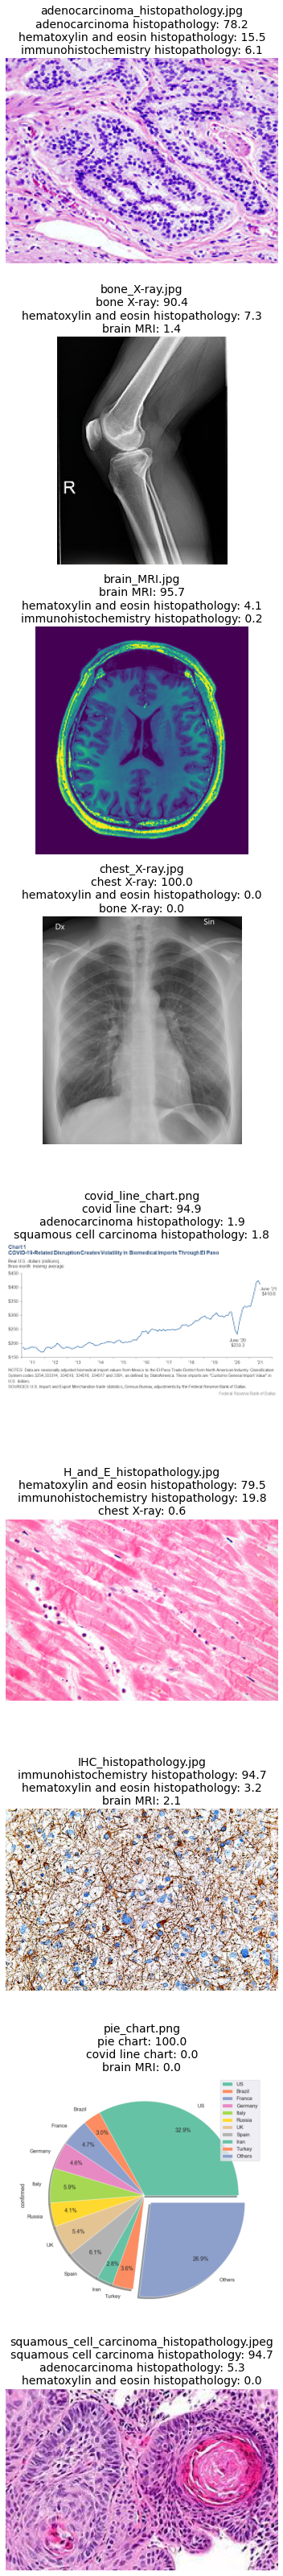

In [23]:
import matplotlib.pyplot as plt

def plot_images_with_metadata(images, metadata):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(5, 5 * num_images))

    for i, (img_path, metadata) in enumerate(zip(images, metadata)):
        img = Image.open(img_path)
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{metadata['filename']}\n{metadata['top_probs']}", fontsize=14)

    plt.tight_layout()
    plt.show()

metadata_list = []

top_k = 3
for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]
    img_name = img.split('/')[-1]

    top_probs = []
    top_k = len(labels) if top_k == -1 else top_k
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        top_probs.append(f"{labels[jth_index]}: {logits[i][jth_index] * 100:.1f}")

    metadata = {'filename': img_name, 'top_probs': '\n'.join(top_probs)}
    metadata_list.append(metadata)

plot_images_with_metadata(test_imgs, metadata_list)

# CONCH
- paper : Ming Y. Lu, Bowen Chen, Drew F. K. Williamson, Richard J. Chen, Ivy Liang, Tong Ding, Guillaume Jaume, Igor Odintsov, Andrew Zhang, Long Phi Le, Georg Gerber, Anil V Parwani, Faisal Mahmood, "Towards a Visual-Language Foundation Model for Computational Pathology
" 
- abstract : The accelerated adoption of digital pathology and advances in deep learning have enabled the development of powerful models for various pathology tasks across a diverse array of diseases and patient cohorts. However, model training is often difficult due to label scarcity in the medical domain and the model's usage is limited by the specific task and disease for which it is trained. Additionally, most models in histopathology leverage only image data, a stark contrast to how humans teach each other and reason about histopathologic entities. We introduce CONtrastive learning from Captions for Histopathology (CONCH), a visual-language foundation model developed using diverse sources of histopathology images, biomedical text, and notably over 1.17 million image-caption pairs via task-agnostic pretraining. Evaluated on a suite of 13 diverse benchmarks, CONCH can be transferred to a wide range of downstream tasks involving either or both histopathology images and text, achieving state-of-the-art performance on histology image classification, segmentation, captioning, text-to-image and image-to-text retrieval. CONCH represents a substantial leap over concurrent visual-language pretrained systems for histopathology, with the potential to directly facilitate a wide array of machine learning-based workflows requiring minimal or no further supervised fine-tuning.
- url [arxiv](https://arxiv.org/abs/2307.12914)

# Datasets
- [Pubmed Central OA](https://huggingface.co/datasets/axiong/pmc_oa)